In [12]:
!pip install ta==0.10.2
!pip install yfinance
!pip install ipython-autotime

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ta
import math
import json
from joblib import Parallel, delayed

from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
%matplotlib inline
%load_ext autotime
print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
tensorflow version: 2.15.0
Num GPUs Available:  1


True

time: 5.33 ms (started: 2024-11-17 14:06:16 +00:00)


In [40]:
# Download historical price data for a stock
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']
df = [yf.download(ticker, start="2014-11-01", end="2024-11-01") for ticker in tickers]

#download to json
# data = {}

# for symbol in ticker:
#     # Download the historical price data for each symbol
#     hist_data = yf.download(symbol, start="2015-01-01", end="2023-01-01")
    
#     #Convert the historical price data to a dictionary with string keys
#     hist_data_dict = hist_data.to_dict('index')
#     hist_data_dict = {str(k): v for k, v in hist_data_dict.items()}
    
#     # Add the historical price data to the data dictionary
#     data[symbol] = hist_data_dict

# # Save the data dictionary to a JSON file
# with open("historical_price_data.json", "w") as f:
#     json.dump(data, f)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

time: 955 ms (started: 2024-11-17 14:06:16 +00:00)


Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days and Bollinger Bands')

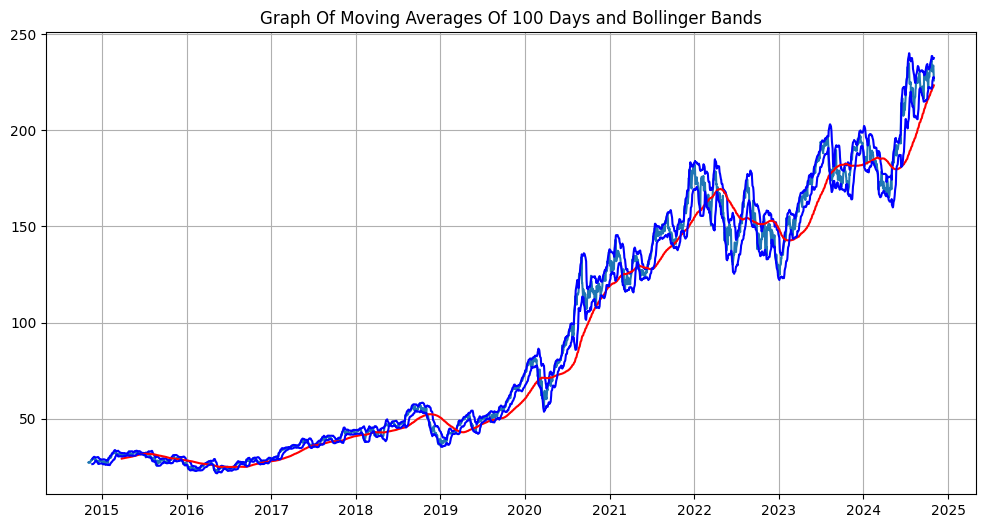

time: 497 ms (started: 2024-11-17 14:06:17 +00:00)


In [41]:
aapl_close = df[0]["Close"].squeeze() 
ma100 = aapl_close.rolling(100).mean()

BB = ta.volatility.BollingerBands(aapl_close, window=14)
high_band = BB.bollinger_hband()
low_band = BB.bollinger_lband()
    
plt.figure(figsize = (12,6))
plt.plot(aapl_close)
plt.plot(high_band, 'b')
plt.plot(ma100, 'r')
plt.plot(low_band, 'b')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days and Bollinger Bands')

In [42]:
# Feature Engineering Function
def process_stock(stock_df):
    close_prices = stock_df["Close"].squeeze()
    high_prices = stock_df["High"].squeeze()
    low_prices = stock_df["Low"].squeeze()

    # Indicators
    stock_df["RSI"] = ta.momentum.rsi(close_prices, window=14)
    stock_df["SMA7"] = close_prices.rolling(window=7).mean()
    stock_df["SMA14"] = close_prices.rolling(window=14).mean()
    stock_df["SMA21"] = close_prices.rolling(window=21).mean()

    ema_windows = [7, 25, 99, 200]
    for window in ema_windows:
        stock_df[f"EMA{window}"] = ta.trend.ema_indicator(close_prices, window=window)

    stock_df["MACD"] = ta.trend.MACD(close_prices).macd()

    bb = ta.volatility.BollingerBands(close_prices, window=14)
    stock_df["upper_band"] = bb.bollinger_hband()
    stock_df["lower_band"] = bb.bollinger_lband()

    stock_df["WR"] = ta.momentum.WilliamsRIndicator(high_prices, low_prices, close_prices).williams_r()
    stock_df["CCI"] = ta.trend.CCIIndicator(close_prices, high_prices, low_prices).cci()
    stock_df["Ulcer Index"] = ta.volatility.UlcerIndex(close_prices).ulcer_index()

    stock_df["close_next_day"] = close_prices.shift(-1).ffill(limit=2)

    # Drop NaN rows
    stock_df.dropna(inplace=True)

    return stock_df

# Process all stocks in parallel
df = Parallel(n_jobs=-1)(delayed(process_stock)(stock) for stock in df)

# # Save processed data
# for i, stock in enumerate(tickers):
#     df[i].to_csv(f"./csv/{stock}_processed.csv")

time: 2.06 s (started: 2024-11-17 14:06:18 +00:00)


In [43]:
i = 0
reframed_list = []
values_list = []
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []

for i in range(len(df)):
    close_prices = df[i]["Close"].squeeze()
    high_prices = df[i]["High"].squeeze()
    low_prices = df[i]["Low"].squeeze()

    df[i]["RSI"] = ta.momentum.rsi(close_prices, window=14)

    # Calculate SMA with rolling() function
    df[i]["SMA7"] = close_prices.rolling(window=7).mean()
    df[i]["SMA14"] = close_prices.rolling(window=14).mean()
    df[i]["SMA21"] = close_prices.rolling(window=21).mean()
    

    df[i]['EMA7'] = ta.trend.ema_indicator(close_prices, window=7)
    df[i]['EMA25'] = ta.trend.ema_indicator(close_prices, window=25)
    df[i]['EMA99'] = ta.trend.ema_indicator(close_prices, window=99)
    df[i]['EMA200'] = ta.trend.ema_indicator(close_prices, window=200)

    df[i]["MACD"] = ta.trend.MACD(close_prices, window_slow=26, window_fast=12, window_sign=9).macd()

    # Calculate the upper and lower Bollinger Bands
    BB = ta.volatility.BollingerBands(close_prices, window=14)
    df[i]["Upper Band"] = BB.bollinger_hband()
    df[i]["Lower Band"] = BB.bollinger_lband()

    df[i]["WR"] = ta.momentum.WilliamsRIndicator(high_prices, low_prices, close_prices).williams_r()
    df[i]["CCI"] = ta.trend.CCIIndicator(close_prices, high_prices, low_prices).cci()
    df[i]["Ulcer Index"] = ta.volatility.UlcerIndex(close_prices).ulcer_index()

    df[i].dropna(inplace=True)
    df[i]["Close Next Day"] = close_prices.shift(-1).ffill(limit=2)

    # ensure all data is float
    values = df[i].values
    values = values.astype("float32")
    values_list.append(values)
    
    # put close column to index 0
    # cols = df[i].columns.tolist()
    # cols = cols[3:4] + cols[:3] + cols[4:]
    # df[i] = df[i][cols]

    # # normalize features
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled = scaler.fit_transform(values)

    # # frame as supervised learning
    # reframed = series_to_supervised(scaled, 1, 1)

    # # drop columns we don't want to predict
    # reframed.drop(reframed.columns[20:], axis=1, inplace=True)
    # reframed_list.append(reframed)
    i += 1

time: 1.81 s (started: 2024-11-17 14:06:20 +00:00)


In [48]:
# Combine all stock data for global scaling
global_scaler = MinMaxScaler(feature_range=(0, 1))
combined_values = np.vstack(values_list)
scaled_combined = global_scaler.fit_transform(combined_values)

# Split data back into individual stocks
scaled_values_list = []
start_idx = 0
for values in values_list:
    scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
    start_idx += len(values)

# Training and testing split
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
for scaled_values in scaled_values_list:
    n_train = int(len(scaled_values) * 0.8)
    train = scaled_values[:n_train, :]
    test = scaled_values[n_train:, :]

    # Split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # Reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    train_X_list.append(train_X)
    train_y_list.append(train_y)
    test_X_list.append(test_X)
    test_y_list.append(test_y)

# Combine all data for unified training
train_X = np.vstack(train_X_list)
train_y = np.hstack(train_y_list)
test_X = np.vstack(test_X_list)
test_y = np.hstack(test_y_list)

time: 11.3 ms (started: 2024-11-17 14:07:18 +00:00)


In [49]:
# LSTM Model
model = Sequential()
model.add(LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=1))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mae')

time: 371 ms (started: 2024-11-17 14:07:18 +00:00)


In [50]:
# Train the model
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
503/503 - 5s - loss: 0.0350 - val_loss: 0.0102 - 5s/epoch - 10ms/step
Epoch 2/50
503/503 - 2s - loss: 0.0062 - val_loss: 0.0061 - 2s/epoch - 4ms/step
Epoch 3/50
503/503 - 3s - loss: 0.0049 - val_loss: 0.0059 - 3s/epoch - 5ms/step
Epoch 4/50
503/503 - 2s - loss: 0.0044 - val_loss: 0.0060 - 2s/epoch - 5ms/step
Epoch 5/50
503/503 - 3s - loss: 0.0041 - val_loss: 0.0057 - 3s/epoch - 5ms/step
Epoch 6/50
503/503 - 2s - loss: 0.0038 - val_loss: 0.0056 - 2s/epoch - 5ms/step
Epoch 7/50
503/503 - 2s - loss: 0.0036 - val_loss: 0.0055 - 2s/epoch - 5ms/step
Epoch 8/50
503/503 - 2s - loss: 0.0035 - val_loss: 0.0054 - 2s/epoch - 4ms/step
Epoch 9/50
503/503 - 2s - loss: 0.0035 - val_loss: 0.0053 - 2s/epoch - 4ms/step
Epoch 10/50
503/503 - 2s - loss: 0.0034 - val_loss: 0.0052 - 2s/epoch - 4ms/step
Epoch 11/50
503/503 - 2s - loss: 0.0033 - val_loss: 0.0052 - 2s/epoch - 5ms/step
Epoch 12/50
503/503 - 2s - loss: 0.0033 - val_loss: 0.0050 - 2s/epoch - 5ms/step
Epoch 13/50
503/503 - 2s - loss: 0.0

14/14 [==============================] - 0s 2ms/step
MAE: 4.662146091461182
MSE: 44.74565887451172
RMSE: 6.6892194747924805


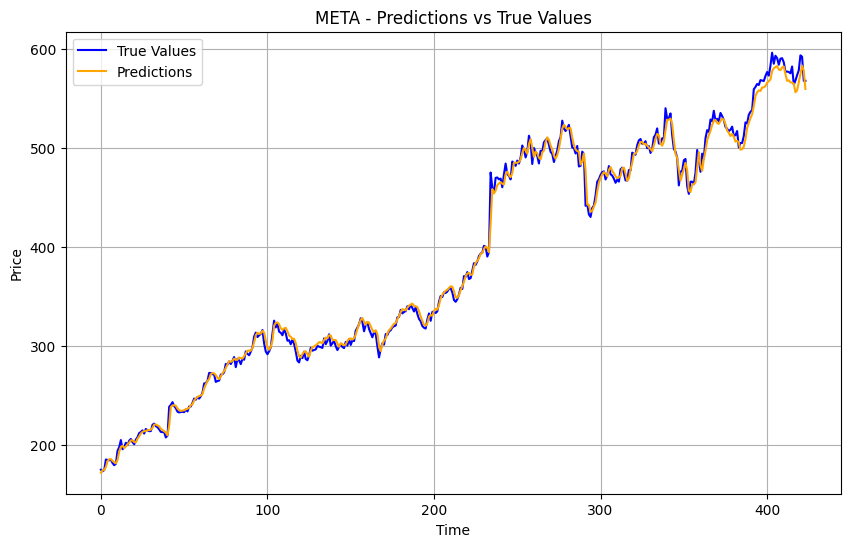

time: 351 ms (started: 2024-11-17 14:14:02 +00:00)


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate the model
def evaluate_model(model, test_X, test_y, scaler):
    # Make predictions
    predictions = model.predict(test_X)
    
    # Rescale predictions and true values back to original scale
    predictions_rescaled = scaler.inverse_transform(
        np.hstack([test_X[:, 0, :], predictions]).reshape(-1, test_X.shape[2] + 1))[:, -1]
    test_y_rescaled = scaler.inverse_transform(
        np.hstack([test_X[:, 0, :], test_y.reshape(-1, 1)]).reshape(-1, test_X.shape[2] + 1))[:, -1]
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test_y_rescaled, predictions_rescaled)
    mse = mean_squared_error(test_y_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return test_y_rescaled, predictions_rescaled

# Plotting predictions vs true values
def plot_predictions(true_values, predicted_values, stock_name="Stock"):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predicted_values, label="Predictions", color="orange")
    plt.title(f"{stock_name} - Predictions vs True Values")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Example: Evaluate and plot predictions for the last stock in the dataset
iterator = -1  # Select the last stock; change index as needed
test_y_rescaled, predictions_rescaled = evaluate_model(
    model, test_X_list[iterator], test_y_list[iterator], global_scaler
)

# Plot the results
plot_predictions(test_y_rescaled, predictions_rescaled, stock_name=tickers[iterator])